## Imports


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
import ast
import joblib


## Load and Prepare Data



In [30]:
df = pd.read_csv("previous_data.csv")
df.dropna(inplace=True)

X_columns = ['temperature', 'soil_temperature', 'soil_moisture', 'precipitation', 'sunshine_duration', 'humid']
X = df[X_columns]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ensure growing_countries is a list
df['growing_countries'] = df['growing_countries'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


## Optimal K value

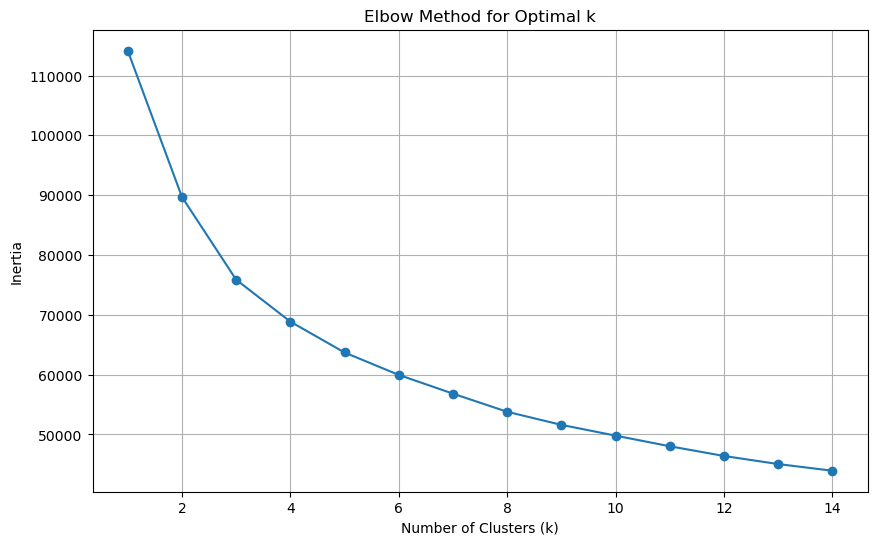

In [31]:
inertia = []
k_range = range(1, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()


## Training k- means model

In [32]:
optimal_k = 4  # Based on elbow plot or domain knowledge
main_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = main_kmeans.fit_predict(X_scaled)


## k value of subclusters

In [33]:
def find_best_k(X, k_min=2, k_max=3):
    best_score = -1
    best_k = k_min
    for k in range(k_min, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_k = k
    return best_k


## create and store subclusters

In [34]:
df['sub_cluster'] = None
sub_kmeans_models = {}

for main_cluster in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == main_cluster]
    X_cluster = scaler.transform(cluster_data[X_columns])

    best_k = find_best_k(X_cluster)
    sub_kmeans = KMeans(n_clusters=best_k, random_state=42)
    sub_labels = sub_kmeans.fit_predict(X_cluster)

    df.loc[df['cluster'] == main_cluster, 'sub_cluster'] = [f"{main_cluster}_{label}" for label in sub_labels]
    sub_kmeans_models[main_cluster] = sub_kmeans


## recommendation function

In [35]:
subcluster_map = {
    '0_0': 1, '0_1': 2,
    '1_0': 3, '1_1': 4,
    '2_0': 5, '2_1': 6,
    '3_0': 7, '3_1': 8,
}

def recommend_closest_seeds(new_data, country=None, top_n=None):
    new_scaled = scaler.transform([new_data])

    main_cluster_id = main_kmeans.predict(new_scaled)[0]

    sub_model = sub_kmeans_models[main_cluster_id]
    sub_cluster_id = sub_model.predict(new_scaled)[0]
    full_sub_label = f"{main_cluster_id}_{sub_cluster_id}"

    mapped_cluster_int = subcluster_map.get(full_sub_label, -1)
    seeds_in_subcluster = df[df['sub_cluster'] == full_sub_label].copy()

    if country:
        seeds_in_subcluster = seeds_in_subcluster[seeds_in_subcluster['growing_countries'].apply(
            lambda countries: any(country.lower() == c.lower() for c in countries)
        )]

    if seeds_in_subcluster.empty:
        return main_cluster_id, full_sub_label, mapped_cluster_int, [], []

    sub_scaled = scaler.transform(seeds_in_subcluster[X_columns])
    distances = euclidean_distances(sub_scaled, new_scaled).flatten()

    seeds_in_subcluster['distance'] = distances
    seeds_in_subcluster = seeds_in_subcluster.sort_values(by='distance')

    if top_n is not None:
        seeds_in_subcluster = seeds_in_subcluster.head(top_n)

    return main_cluster_id, full_sub_label, mapped_cluster_int, seeds_in_subcluster['seed_id'].tolist(), seeds_in_subcluster['distance'].tolist()
    # Add the mapped sub-cluster integer to the DataFrame
df['mapped_sub_cluster'] = df['sub_cluster'].map(subcluster_map)

    # Save the updated DataFrame to the CSV
df.to_csv('new_data.csv', index=False)


## Testing

In [36]:
new_data = [20, 15, 0.3, 800, 5000, 60]
user_country = ""

main_cluster, sub_cluster_label, cluster_int, recommended_seeds, distances = recommend_closest_seeds(
    new_data, country=user_country, top_n=None
)

print(f"Main Cluster: {main_cluster}")
print(f"Sub-Cluster: {sub_cluster_label} (Mapped ID: {cluster_int})")
print(f"Recommended {len(recommended_seeds)} seed(s):")

for sid, dist in zip(recommended_seeds, distances):
    print(f"Seed ID: {sid}, Distance: {dist:.4f}")


Main Cluster: 3
Sub-Cluster: 3_0 (Mapped ID: 7)
Recommended 2131 seed(s):
Seed ID: 10, Distance: 0.0000
Seed ID: 20621, Distance: 0.0785
Seed ID: 6615, Distance: 0.0785
Seed ID: 1732, Distance: 0.0785
Seed ID: 18115, Distance: 0.0785
Seed ID: 4598, Distance: 0.0785
Seed ID: 373, Distance: 0.0785
Seed ID: 5638, Distance: 0.0785
Seed ID: 2359, Distance: 0.1569
Seed ID: 16061, Distance: 0.1605
Seed ID: 4981, Distance: 0.1726
Seed ID: 4018, Distance: 0.1786
Seed ID: 13043, Distance: 0.1786
Seed ID: 19451, Distance: 0.1786
Seed ID: 6234, Distance: 0.1786
Seed ID: 3628, Distance: 0.1786
Seed ID: 6227, Distance: 0.1961
Seed ID: 4487, Distance: 0.1961
Seed ID: 13278, Distance: 0.2245
Seed ID: 4045, Distance: 0.2354
Seed ID: 20349, Distance: 0.2354
Seed ID: 12498, Distance: 0.2354
Seed ID: 4601, Distance: 0.2534
Seed ID: 20365, Distance: 0.2534
Seed ID: 3545, Distance: 0.3094
Seed ID: 16060, Distance: 0.3210
Seed ID: 21159, Distance: 0.3304
Seed ID: 945, Distance: 0.3304
Seed ID: 13786, Distanc

C:\Users\shado\anaconda3\envs\gripai\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



## Visualization

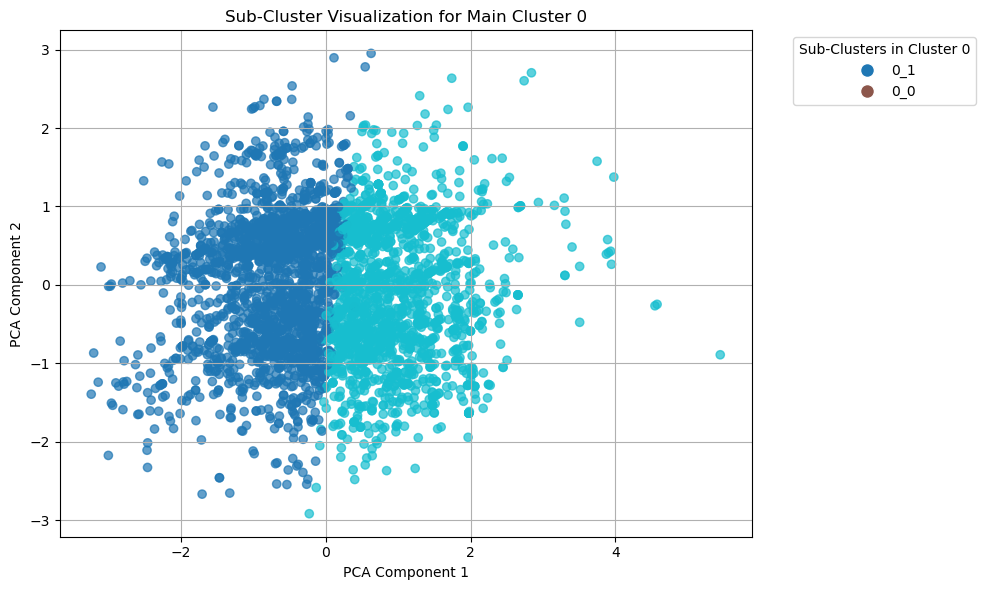

In [37]:
def visualize_subclusters_for_main_cluster(cluster_id):
    cluster_df = df[df['cluster'] == cluster_id]
    X_cluster = scaler.transform(cluster_df[X_columns])

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_cluster)

    unique_subs = cluster_df['sub_cluster'].unique()
    color_map = {label: idx for idx, label in enumerate(unique_subs)}
    colors = cluster_df['sub_cluster'].map(color_map)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap='tab10', alpha=0.7)

    handles = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=plt.cm.tab10(idx / len(unique_subs)), markersize=10)
               for idx in range(len(unique_subs))]
    plt.legend(handles, unique_subs, title=f"Sub-Clusters in Cluster {cluster_id}", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'Sub-Cluster Visualization for Main Cluster {cluster_id}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

visualize_subclusters_for_main_cluster(0)


In [38]:
pca = PCA()
pca.fit(X)
explained = pca.explained_variance_ratio_
print(explained)


[9.99403193e-01 5.96270490e-04 3.31631375e-07 1.72250429e-07
 3.25335559e-08 3.06110052e-11]


This tells us:

PC1 captures ~99.94% of the total variance.

PC2 captures ~0.059%.

The rest are negligible (basically noise).

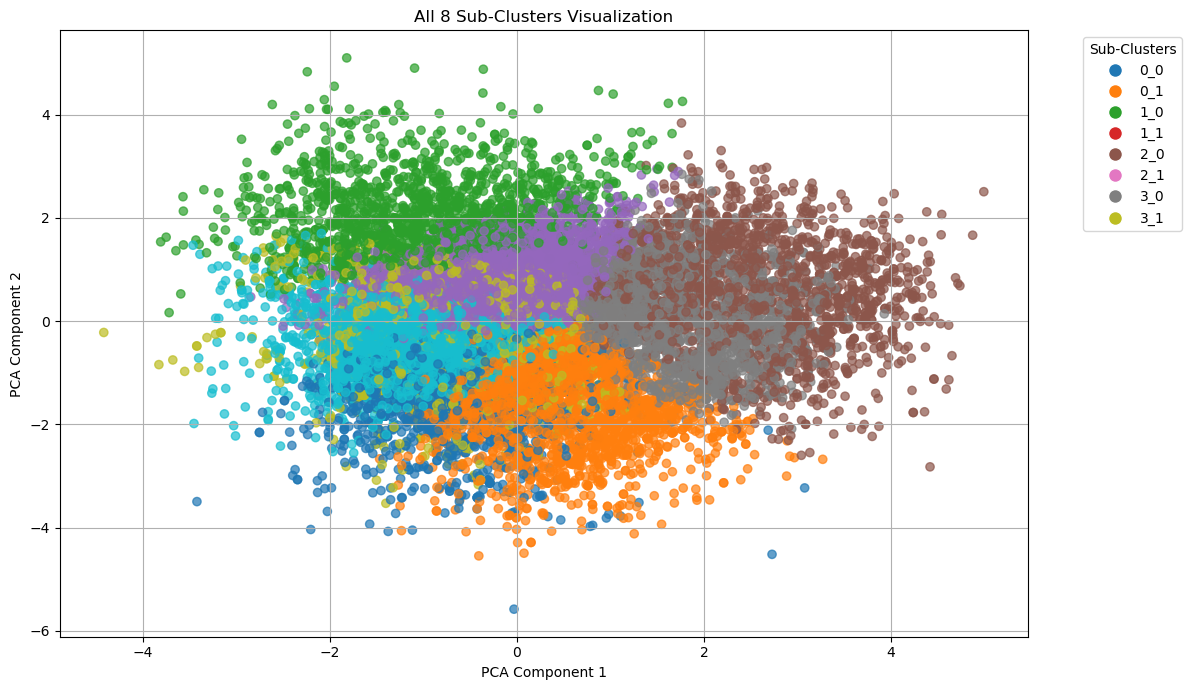

In [39]:
# Apply PCA to reduce dimensions for entire dataset
pca = PCA(n_components=2)
X_all_scaled = scaler.transform(df[X_columns])
X_pca = pca.fit_transform(X_all_scaled)

# Create a color map for unique sub-clusters
unique_subclusters = sorted(df['sub_cluster'].unique())
color_map = {label: idx for idx, label in enumerate(unique_subclusters)}
colors = df['sub_cluster'].map(color_map)

# Plotting
plt.figure(figsize=(12, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap='tab10', alpha=0.7)

# Create custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=plt.cm.tab10(color_map[label] / len(unique_subclusters)),
               label=label, markersize=10)
    for label in unique_subclusters
]

plt.legend(handles=handles, title="Sub-Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('All 8 Sub-Clusters Visualization')
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
import plotly.express as px
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions to 3
pca = PCA(n_components=3)
X_all_scaled = scaler.transform(df[X_columns])
X_pca = pca.fit_transform(X_all_scaled)

# Create a temporary DataFrame for Plotly with PCA components and sub-cluster info
plot_df = df.copy()
plot_df['PCA1'] = X_pca[:, 0]
plot_df['PCA2'] = X_pca[:, 1]
plot_df['PCA3'] = X_pca[:, 2]

# Plotly interactive 3D scatter plot
fig = px.scatter_3d(
    plot_df,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='sub_cluster',
    title="All 8 Sub-Clusters Visualization (3D)",
    labels={
        'PCA1': 'PCA Component 1',
        'PCA2': 'PCA Component 2',
        'PCA3': 'PCA Component 3'
    },
    color_discrete_sequence=px.colors.qualitative.Set1
)

# Show the plot
fig.show()


In [41]:
df.to_csv('new_data.csv', index=False)


## Save the models

In [42]:
joblib.dump(scaler, 'models/scaler.joblib')
joblib.dump(main_kmeans, 'models/main_kmeans.joblib')
joblib.dump(sub_kmeans_models, 'models/sub_kmeans_models.joblib')


['models/sub_kmeans_models.joblib']